# Model Content Comparison 
The purpose of this notebook is to compare the current version of the RBC-GEM to earlier versions.
## Setup
### Import packages

In [1]:
from collections import defaultdict
from itertools import permutations
from operator import itemgetter
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from cobra.core import DictList
from cobra.manipulation import remove_genes, rename_genes
from cobra.util.array import create_stoichiometric_matrix
from rbc_gem_utils import (ANNOTATION_PATH, CURATION_PATH, DATABASE_PATH,
                           GEM_NAME, GEM_URL, INTERIM_PATH, MODEL_PATH,
                           RESULTS_PATH, ROOT_PATH, build_string,
                           read_cobra_model, read_rbc_model, show_versions)
from rbc_gem_utils.util import ensure_iterable
from rbc_gem_utils.visualization import cmap_map

# Display versions of last time notebook ran and worked
show_versions()
plt.rcParams["font.family"] = "Arial"


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM models
### Current model

In [2]:
data_path = Path("data").resolve()
models_path = Path("models").resolve()
figures_path = Path("figures").resolve()
version = "1.2.0"

imagetype = "png"
transparent = True
save_figures = True

ftype = "xml"
current_model = read_cobra_model(f"{models_path}/{GEM_NAME.replace('-', '_')}.{ftype}")

current_version = version

current_model.metabolites.sort()
current_model.genes.sort()
current_model.reactions.sort()
current_model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,14776be90
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


### Earlier models

In [3]:
# Probably a better way to do this instead of erroring out.
download = False
version = "0.2.0"
ftype = "xml"

filepath = f"{models_path}/{GEM_NAME.replace('-', '_')}_{version}.{ftype}"

if download:
    response = requests.get(f"{GEM_URL}/{version}/{MODEL_PATH}/{GEM_NAME}.{ftype}")
    response.raise_for_status()

    # Write file
    # Is there a better way of checking whether binary file?
    if not response.encoding:
        with open(filepath, "wb") as file:
            file.write(response.content)
    else:
        with open(filepath, "w") as file:
            file.write(response.text)

prev_model_020 = read_cobra_model(filepath)
prev_model_020.metabolites.sort()
prev_model_020.genes.sort()
prev_model_020.reactions.sort()
prev_model_020.groups.sort()
# For comparison
group = prev_model_020.groups.get_by_id("Transport reactions")
group.id = "Transport, extracellular"


# For comparison rename genes and remove splice isoforms
rename_genes(
    prev_model_020,
    {g.id: g.annotation.get("hgnc.symbol") for g in prev_model_020.genes},
)
prev_model_020.repair()
prev_model_020

Name,iAB_RBC_283
Memory address,14abebe10
Number of metabolites,342
Number of reactions,469
Number of genes,283
Number of groups,33
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [4]:
len(prev_model_020.reactions.query(lambda x: x.subsystem != "Pseudoreactions"))

370

In [5]:
model_list = [prev_model_020, current_model]
model_data = defaultdict(dict)

save_figures = True
transparent = False
imagetype = "svg"

### Comparison of subsystems

In [6]:
df_pathways = pd.read_csv(
    f"{data_path}/subsystems.tsv", sep="\t", index_col=None, dtype=str
)
df_pathways = df_pathways.fillna("")
# Group "Metabolism of other amino acids" with amino acids rather than treat as "other"
df_pathways["category"] = df_pathways["category"].replace(
    "Metabolism of other amino acids", "Amino acid metabolism"
)
df_pathways

,name,category,kegg.pathway.name,kegg.pathway,notes
0,"Alanine, aspartate and glutamate metabolism",Amino acid metabolism,"Alanine, aspartate and glutamate metabolism",hsa00250,
1,Arginine and proline metabolism,Amino acid metabolism,Arginine and proline metabolism,hsa00330,
2,Cysteine and methionine metabolism,Amino acid metabolism,Cysteine and methionine metabolism,hsa00270,
3,"Glycine, serine and threonine metabolism",Amino acid metabolism,"Glycine, serine and threonine metabolism",hsa00260,
4,Histidine metabolism,Amino acid metabolism,Histidine metabolism,hsa00340,
...,...,...,...,...,...
73,Aminoacyl-tRNA biosynthesis,Translation,Aminoacyl-tRNA biosynthesis,has00970,
74,"Transport, extracellular",Transport reactions,,,Representative subsystem for all transport rea...
75,5-fluorouracil metabolism,Xenobiotics biodegradation and metabolism,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."
76,Azathioprine and 6-mercaptopurine metabolism,Xenobiotics biodegradation and metabolism,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."


In [7]:
# Categories that should be excluded from the figure
categories_to_exclude = {"Pseudoreactions", "Model total"}
# Main categories in figure and abbreviations, all unmapped categories are mapped to "Other"
categories_to_keep = {
    "Amino acid metabolism": mpl.cm.spring,
    "Carbohydrate metabolism": mpl.cm.Greens,
    "Lipid metabolism": mpl.cm.Blues,
    "Metabolism of cofactors and vitamins": mpl.cm.summer,
    "Nucleotide metabolism": mpl.cm.winter,
    "Reactive species": mpl.cm.Reds,
    "Transport reactions": mpl.cm.Purples,
    "Other": mpl.cm.gray_r,
}
use_abbrevs = True
abbrevs = {
    "Amino acid metabolism": "A",
    "Carbohydrate metabolism": "C",
    "Lipid metabolism": "L",
    "Metabolism of cofactors and vitamins": "V",
    "Nucleotide metabolism": "N",
    "Reactive species": "R",
    "Transport reactions": "T",
    "Other": "O",
}
barsize = 0.8
fontsize = 12
cmax = 0.8
cmin = 0.3


colormaps_normal = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x * 1, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)
colormaps_light = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x / 2 + 0.5, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)

Number of unique genes in iAB_RBC_283:		283
Number of unique metabolites in iAB_RBC_283:	267
Number of biochemical reactions in iAB_RBC_283:	370

Number of unique genes in RBC_GEM:		820
Number of unique metabolites in RBC_GEM:	1685
Number of biochemical reactions in RBC_GEM:	2723



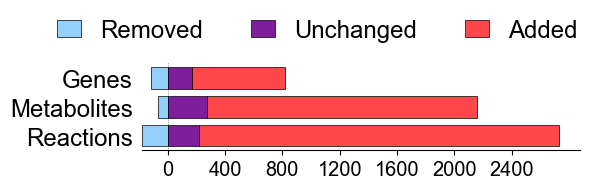

In [8]:
categories = ["Removed", "Unchanged", "Added"]
colors_dict = dict(
    zip(categories, ["xkcd:light blue", "xkcd:purple", "xkcd:light red"])
)
attribute_types = ["reactions", "metabolites", "genes"]
edgecolor = "black"
linewidth = 0.5
data = defaultdict(dict)
for attribute_type in attribute_types:
    try:
        df_removed = pd.read_csv(
            f"{data_path}/{attribute_type}_removed.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
    except FileNotFoundError:
        df_removed = pd.DataFrame([], columns=[attribute_type], dtype=str)
    if attribute_type == "reactions":
        obj_lists = [
            getattr(model, attribute_type).query(lambda x: not x.boundary)
            for model in model_list
        ]
    else:
        obj_lists = [getattr(model, attribute_type) for model in model_list]

    shared = obj_lists[0].query(lambda x: x.id not in df_removed[attribute_type].values)
    removed = df_removed[attribute_type].values
    new = obj_lists[1].query(lambda x: x.id not in set(shared.list_attr("id")))
    data[attribute_type].update(
        dict(zip(categories, list(map(len, [removed, shared, new]))))
    )


df_data = pd.DataFrame.from_dict(data, orient="index")
df_data.index = df_data.index.str.capitalize()

fig, ax_general = plt.subplots(figsize=(6, 2))
total = df_data.cumsum(axis=1)
offsets = df_data[categories[0]].values
labels = [s.capitalize() for s in attribute_types]
tick_pos = [0.05, 0.11, 0.17]
for name, column in df_data.items():
    ax_general.barh(
        tick_pos,
        column.values,
        height=0.045,
        left=total[name] - column.values - offsets,
        color=colors_dict[name],
        edgecolor=edgecolor,
        linewidth=linewidth,
    )
    ax_general.set_yticks(tick_pos, labels=attribute_types)
    ax_general.set_yticklabels([s.capitalize() for s in attribute_types])

# Remove spines
ax_general.spines["right"].set_visible(False)
ax_general.spines["top"].set_visible(False)
ax_general.spines["left"].set_visible(False)
ax_general.axvline(0, linestyle=":", color="black", alpha=0.8, linewidth=linewidth)
xticks = list(np.linspace(0, 2400, 7))
ax_general.set_xticks(xticks)
ax_general.xaxis.set_major_formatter(lambda x, pos: int(abs(x)))
ax_general.yaxis.set_tick_params(left=False, labelsize="xx-large")
ax_general.xaxis.set_tick_params(labelsize="x-large")
legend = ax_general.legend(
    handles=[
        mpl.patches.Patch(
            label=label, facecolor=color, edgecolor=edgecolor, linewidth=linewidth
        )
        for label, color in colors_dict.items()
    ],
    frameon=False,
    edgecolor="black",
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.4, 1, 0, 0),
    fontsize="xx-large",
    handlelength=1,
)

fig.tight_layout()

print(
    f"Number of unique genes in {prev_model_020.id}:\t\t{len([x.id for x in prev_model_020.genes])}\n"
    f"Number of unique metabolites in {prev_model_020.id}:\t{len(set([x.id.replace(f'_{x.compartment}', '') for x in prev_model_020.metabolites]))}\n"
    f"Number of biochemical reactions in {prev_model_020.id}:\t{len(prev_model_020.reactions.query(lambda x: x.subsystem != 'Pseudoreactions'))}\n"
)

print(
    f"Number of unique genes in {current_model.id}:\t\t{len([x.id for x in current_model.genes])}\n"
    f"Number of unique metabolites in {current_model.id}:\t{len(set([x.id.replace(f'_{x.compartment}', '') for x in current_model.metabolites]))}\n"
    f"Number of biochemical reactions in {current_model.id}:\t{len(current_model.reactions.query(lambda x: x.subsystem != 'Pseudoreactions'))}\n"
)
if save_figures:
    fig.savefig(
        f"{figures_path}/Fig1_Panel_GeneralComparision.{imagetype}",
        transparent=transparent,
        dpi=None if imagetype != "png" else 600,
    )

In [9]:
for idx, model in enumerate(model_list):
    data = defaultdict(dict)
    all_reactions = set()
    df_cat_subsystems = df_pathways.groupby("category")["name"].agg(lambda x: list(x))
    for category, subsystem_list in df_cat_subsystems.items():
        if category not in categories_to_keep and category not in categories_to_exclude:
            category = "Other"

        if category not in data:
            data[category] = {"Reactions": set(), "Metabolites": set(), "Genes": set()}
        # print([x for x in subsystem_list if not x in model.groups])
        subsystem_list = [x for x in subsystem_list if x in model.groups]
        reactions = [
            reaction
            for group in model.groups.get_by_any(subsystem_list)
            for reaction in group.members
        ]
        for reaction in reactions:
            all_reactions.update([reaction])
            data[category]["Reactions"].update([reaction])
            data[category]["Metabolites"].update(reaction.metabolites)
            data[category]["Genes"].update(reaction.genes)

    data["Model total"] = {
        "Reactions": model.reactions,
        "Metabolites": model.metabolites,
        "Genes": model.genes,
    }
    df_data = pd.DataFrame(
        {
            key: {k: len(x) for k, x in value_dict.items()}
            for key, value_dict in data.items()
        }
    ).T.sort_index()
    df_data = df_data.loc[df_data.index.difference(categories_to_exclude)]

    model_data[model.id][f"{attribute_type}-cat"] = df_data
    print(model.id, "\n", df_data, "\n")
df_comparison = pd.merge(
    model_data[model_list[0].id][f"{attribute_type}-cat"],
    model_data[model_list[1].id][f"{attribute_type}-cat"],
    left_index=True,
    right_index=True,
    suffixes=(f"_{model_list[0].id}", f"_{model_list[1].id}"),
)
df_comparison

iAB_RBC_283 
                                       Reactions  Metabolites  Genes
Amino acid metabolism                        24           51     27
Carbohydrate metabolism                     104          112     73
Lipid metabolism                             94           94     53
Metabolism of cofactors and vitamins         37           54     28
Nucleotide metabolism                        30           40     57
Other                                         3           10      3
Reactive species                              1            3      1
Transport reactions                          77          152     43 

RBC_GEM 
                                       Reactions  Metabolites  Genes
Amino acid metabolism                       281          276    100
Carbohydrate metabolism                     210          207    148
Lipid metabolism                            711          740    106
Metabolism of cofactors and vitamins        140          176     69
Nucleotide metabolism 

,Reactions_iAB_RBC_283,Metabolites_iAB_RBC_283,Genes_iAB_RBC_283,Reactions_RBC_GEM,Metabolites_RBC_GEM,Genes_RBC_GEM
Amino acid metabolism,24,51,27,281,276,100
Carbohydrate metabolism,104,112,73,210,207,148
Lipid metabolism,94,94,53,711,740,106
Metabolism of cofactors and vitamins,37,54,28,140,176,69
Nucleotide metabolism,30,40,57,171,146,127
Other,3,10,3,232,362,238
Reactive species,1,3,1,103,127,37
Transport reactions,77,152,43,875,890,150
